In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

import folium
import altair as alt
import plotly.express as px

ROOT = Path(r"C:\Users\jinuk\busan-rent-choropleth")  # ✅ 여기만 본인 PC에 맞게
DATA_RAW = ROOT / "data" / "raw"
DATA_GEO = ROOT / "data" / "geo"
OUT = ROOT / "outputs"
(OUT / "maps").mkdir(parents=True, exist_ok=True)
(OUT / "charts").mkdir(parents=True, exist_ok=True)
(OUT / "tables").mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_GEO exists:", DATA_GEO.exists())


ROOT: C:\Users\jinuk\busan-rent-choropleth
DATA_RAW exists: True
DATA_GEO exists: True


In [4]:
# 예: 엑셀 파일명만 바꿔주세요
df_raw = pd.read_excel(DATA_RAW / "아파트(전월세)_실거래가.xlsx", header=12)
df = df_raw.copy()

with open(DATA_GEO / "hangjeongdong_부산광역시.geojson", encoding="utf-8") as f:
    busan_geo = json.load(f)

df.shape, df.columns[:10]


((49472, 21),
 Index(['NO', '시군구', '번지', '본번', '부번', '단지명', '전월세구분', '전용면적(㎡)', '계약년월',
        '계약일'],
       dtype='object'))

In [5]:
def to_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(",", "", regex=False).str.strip(),
        errors="coerce"
    )

df.columns = df.columns.str.strip()
df["전월세구분"] = df["전월세구분"].astype(str).str.strip()

# 구/동 추출: 부산은 '기장군' 때문에 (구|군) 필수
df["구"] = df["시군구"].astype(str).str.extract(r"(\S+(?:구|군))", expand=False)
df["동"] = df["시군구"].astype(str).str.extract(r"(\S+(?:동|읍|면))$", expand=False)

# 숫자 변환
df["보증금(만원)"] = to_num(df["보증금(만원)"])
df["전용면적(㎡)"] = pd.to_numeric(df["전용면적(㎡)"], errors="coerce")
if "월세금(만원)" in df.columns:
    df["월세금(만원)"] = to_num(df["월세금(만원)"])


In [10]:
df["계약년월"] = pd.to_numeric(df["계약년월"], errors="coerce")
df = df.dropna(subset=["계약년월"]).copy()
df["계약년월"] = df["계약년월"].astype(int)

df["거래연"] = df["계약년월"] // 100
df["거래월"] = (df["계약년월"] % 100).astype(int).astype(str).str.zfill(2)

df_2025 = df[df["거래연"] == 2025].copy()
df_2025.shape


(49472, 25)

In [11]:
df_jeon = df_2025[df_2025["전월세구분"] == "전세"].copy()
df_wol  = df_2025[df_2025["전월세구분"] == "월세"].copy()

df_jeon = df_jeon.dropna(subset=["보증금(만원)", "전용면적(㎡)", "구"])
df_jeon = df_jeon[df_jeon["전용면적(㎡)"] > 0]

df_wol = df_wol.dropna(subset=["보증금(만원)", "월세금(만원)", "전용면적(㎡)", "구"])
df_wol = df_wol[df_wol["전용면적(㎡)"] > 0]

print("2025 전세 rows:", len(df_jeon), "/ 2025 월세 rows:", len(df_wol))


2025 전세 rows: 26679 / 2025 월세 rows: 22793


In [12]:
# 월세
gu_wol = df_wol.groupby("구")[["보증금(만원)", "월세금(만원)", "전용면적(㎡)"]].mean().reset_index()
gu_wol["면적당보증금"] = gu_wol["보증금(만원)"] / gu_wol["전용면적(㎡)"]
gu_wol["면적당월세"]   = gu_wol["월세금(만원)"] / gu_wol["전용면적(㎡)"]

top5_wol_rent = gu_wol.sort_values("면적당월세", ascending=False).head(5)
top5_wol_dep  = gu_wol.sort_values("면적당보증금", ascending=False).head(5)

print("상위 월세 자치구 (면적당월세 기준)")
display(top5_wol_rent[["구","면적당월세","월세금(만원)","전용면적(㎡)"]].reset_index(drop=True))

print("상위 보증금 자치구 (월세, 면적당보증금 기준)")
display(top5_wol_dep[["구","면적당보증금","보증금(만원)","전용면적(㎡)"]].reset_index(drop=True))

# 전세
gu_jeon = df_jeon.groupby("구")[["보증금(만원)", "전용면적(㎡)"]].mean().reset_index()
gu_jeon["면적당보증금"] = gu_jeon["보증금(만원)"] / gu_jeon["전용면적(㎡)"]

top5_jeon = gu_jeon.sort_values("면적당보증금", ascending=False).head(5)
print("상위 보증금 자치구(전세, 면적당보증금 기준)")
display(top5_jeon[["구","면적당보증금","보증금(만원)","전용면적(㎡)"]].reset_index(drop=True))

# 저장
gu_wol.to_csv(OUT/"tables/2025_gu_wol.csv", index=False, encoding="utf-8-sig")
gu_jeon.to_csv(OUT/"tables/2025_gu_jeon.csv", index=False, encoding="utf-8-sig")


상위 월세 자치구 (면적당월세 기준)


,구,면적당월세,월세금(만원),전용면적(㎡)
0,해운대구,1.354121,105.361331,77.807906
1,동구,1.282888,75.104762,58.543509
2,수영구,1.221237,80.072634,65.566815
3,남구,1.217907,79.535533,65.305116
4,부산진구,1.100173,54.739355,49.755234


상위 보증금 자치구 (월세, 면적당보증금 기준)


,구,면적당보증금,보증금(만원),전용면적(㎡)
0,연제구,103.782983,6295.445783,60.659712
1,동래구,90.748019,5999.941136,66.116497
2,남구,86.423381,5643.888959,65.305116
3,강서구,81.413985,6025.462116,74.010161
4,북구,81.288702,4994.612053,61.442881


상위 보증금 자치구(전세, 면적당보증금 기준)


,구,면적당보증금,보증금(만원),전용면적(㎡)
0,남구,396.853719,31314.417178,78.906700
1,동래구,388.029983,30138.129184,77.669589
2,동구,383.788632,26804.510234,69.841856
3,해운대구,381.666029,30917.760083,81.007367
4,수영구,380.525443,30290.603530,79.602045


In [13]:
m = folium.Map(location=[35.1796, 129.0756], zoom_start=11, tiles="cartodbpositron")

gu_jeon_map = gu_jeon.rename(columns={"면적당보증금": "면적당보증금_만원"}).copy()

folium.Choropleth(
    geo_data=busan_geo,
    data=gu_jeon_map,
    columns=["구", "면적당보증금_만원"],
    key_on="feature.properties.sggnm",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    nan_fill_opacity=0.0,
    legend_name="부산 구별 ㎡당 전세보증금 (만원) - 2025"
).add_to(m)

m.save(OUT/"maps/2025_busan_jeonse_choropleth.html")
m


In [14]:
num_cols = ["보증금(만원)", "월세금(만원)", "전용면적(㎡)"]
corr = df_wol[num_cols].corr().reset_index().melt("index", var_name="변수2", value_name="상관계수")
corr = corr.rename(columns={"index": "변수1"})

base = alt.Chart(corr).encode(x="변수1:O", y="변수2:O").properties(
    width=400, height=400, title="2025 월세 변수 간 상관관계"
)

heatmap = base.mark_rect().encode(
    color=alt.Color("상관계수:Q").scale(scheme="redblue", domain=[-1, 1])
)
text = base.mark_text(align="center", baseline="middle").encode(
    text=alt.Text("상관계수:Q", format=".2f")
)

chart = heatmap + text
chart.save(OUT/"charts/2025_wolse_corr_heatmap.html")
chart


alt.LayerChart(...)

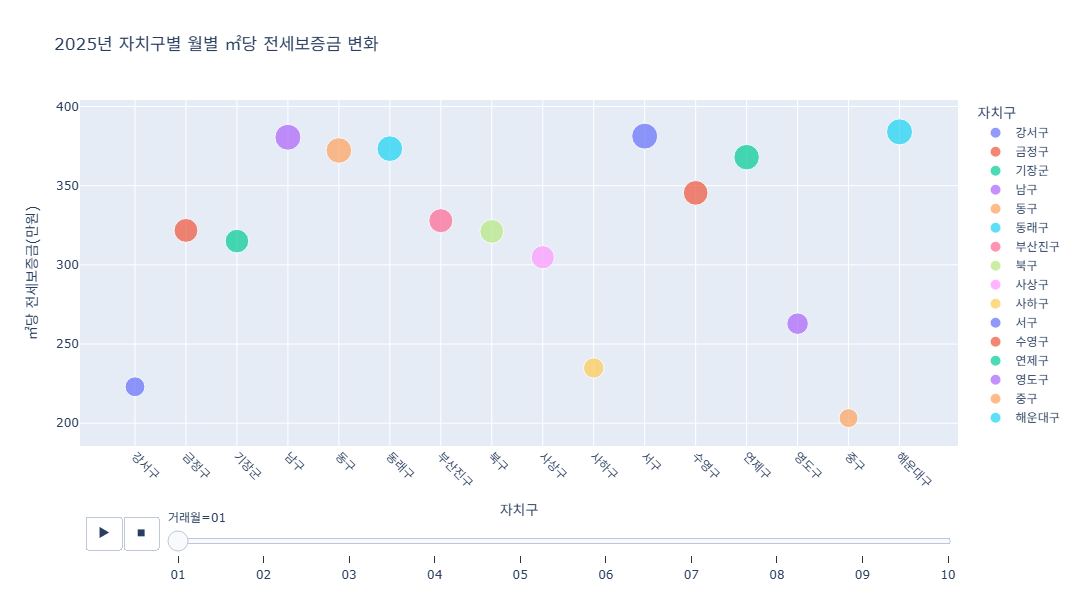

In [15]:
jeonse_monthly = (
    df_jeon.groupby(["구", "거래월"])
    .agg(보증금=("보증금(만원)", "mean"), 면적=("전용면적(㎡)", "mean"))
    .reset_index()
)
jeonse_monthly["면적당보증금_만원"] = jeonse_monthly["보증금"] / jeonse_monthly["면적"]

fig = px.scatter(
    jeonse_monthly.dropna(subset=["면적당보증금_만원"]),
    x="구",
    y="면적당보증금_만원",
    color="구",
    size="면적당보증금_만원",
    animation_frame="거래월",
    animation_group="구",
    hover_name="구",
    title="2025년 자치구별 월별 ㎡당 전세보증금 변화",
    labels={"면적당보증금_만원": "㎡당 전세보증금(만원)", "거래월": "거래월", "구": "자치구"}
)
fig.update_xaxes(tickangle=45)
fig.update_layout(width=1000, height=600)

fig.write_html(OUT/"charts/2025_jeonse_slider.html")
fig


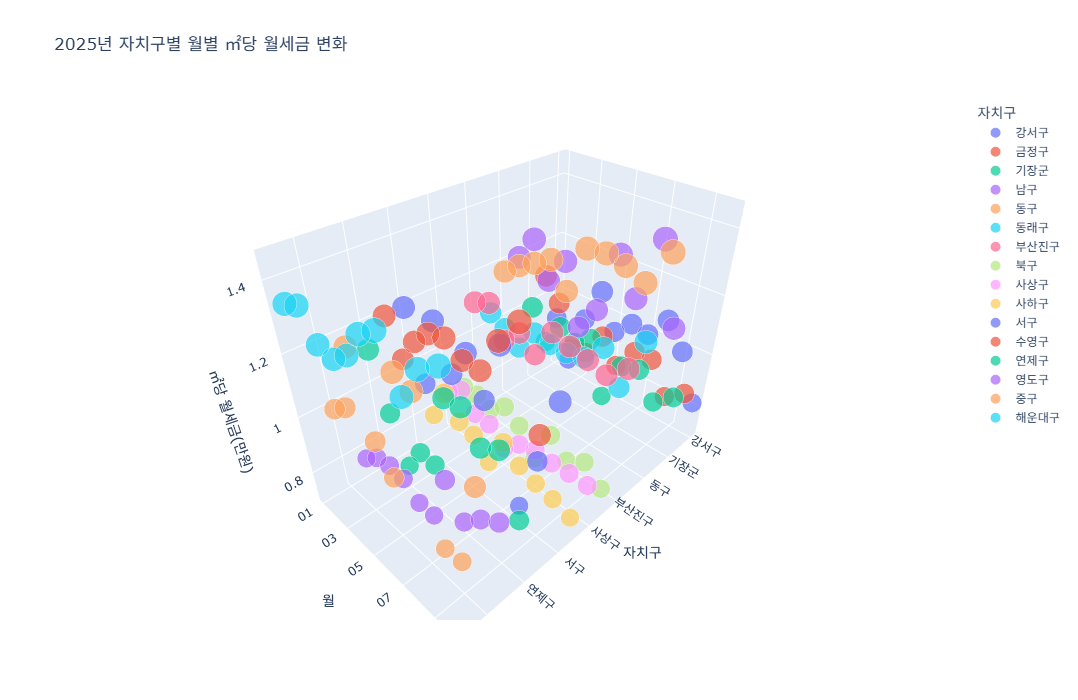

In [16]:
wolse_monthly = (
    df_wol.groupby(["구", "거래월"])
    .agg(월세=("월세금(만원)", "mean"), 면적=("전용면적(㎡)", "mean"))
    .reset_index()
)
wolse_monthly["월세_㎡당_만원"] = wolse_monthly["월세"] / wolse_monthly["면적"]

fig = px.scatter_3d(
    wolse_monthly.dropna(subset=["월세_㎡당_만원"]),
    x="구",
    y="거래월",
    z="월세_㎡당_만원",
    color="구",
    size="월세_㎡당_만원",
    hover_name="구",
    labels={"거래월": "월", "월세_㎡당_만원": "㎡당 월세금(만원)", "구": "자치구"},
    title="2025년 자치구별 월별 ㎡당 월세금 변화"
)
fig.update_layout(width=1000, height=700)

fig.write_html(OUT/"charts/2025_wolse_3d.html")
fig
